In [ ]:
!pip  install opencv-python

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float, img_as_ubyte
import numpy as np
import cv2
from skimage.io import imshow
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure,axis
import pandas as pd

In [ ]:
def find_contour(cnts,img):
    contains = []
    y_ri,x_ri, _ = img.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)
    val = [contains.index(temp) for temp in contains if temp>0]
    return val[0]

In [ ]:
def removebg(img):
    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (55,55),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    black_img = np.empty([1200,1600,3],dtype=np.uint8)
    black_img.fill(0)
    index = find_contour(contours,img)
    cnt = contours[index]
    mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)
    maskedImg = cv2.bitwise_and(img, mask)
    white_pix = [255,255,255]
    black_pix = [0,0,0]
    final_img = maskedImg
    h,w,channels = final_img.shape
    for x in range(0,w):
        for y in range(0,h):
            channels_xy = final_img[y,x]
            if all(channels_xy == black_pix):    
                final_img[y,x] = white_pix
    return final_img

def maskBlack(img):
    black_low = np.array([0,0,0])
    black_high = np.array([20,20,20])
    curr_mask = cv2.inRange(img, black_low, black_high)
    img[curr_mask > 0] = ([255,255,255])
    return img

def removeNoise(img):
    noisy = img_as_float(img)
    sigma_est = np.mean(estimate_sigma(noisy, multichannel=True))
    denoise = denoise_nl_means(noisy, h=1.15*sigma_est, fast_mode=True, patch_size=5, patch_distance=3, multichannel=True)
    denoise_ubyte = img_as_ubyte(denoise)
    return denoise_ubyte

In [ ]:
def showImagesHorizontally(list_of_files):
    fig = figure(figsize =(10, 10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        a.set_title(i,fontsize=16)
        image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        axis('off')
    plt.show()


def pre_process(img):
    global imgO
    img = cv2.resize(img, (1600, 1200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        img = removebg(img)
    except:
        print("Unable to remove Background")
    img = maskBlack(img)
    imgO = img
    img = removeNoise(img)
    img = cv2.GaussianBlur(img, (5,5),0)
    return img
    

def segmentation(img):
    img1 = img
    img2 = img1.reshape(-1, 1)
    img2 = np.float32(img2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 4
    attempts = 10
    ret, label, center = cv2.kmeans(img2, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    labels = label.flatten()
    res = center[labels]
    res2 = res.reshape(img1.shape)
    lstOfImages=[]
    for i in range(4):
        l=[0,1,2,3]
        l.remove(i)
        masked_image = np.copy(imgO)
        masked_image = masked_image.reshape((-1, 3))
        masked_image[labels == l[0]] = [255, 255, 255]
        masked_image[labels == l[1]] = [255, 255, 255]
        masked_image[labels == l[2]] = [255, 255, 255]
        masked_image = masked_image.reshape(imgO.shape)
        lstOfImages.append(masked_image)
    showImagesHorizontally(lstOfImages)
    return lstOfImages

In [ ]:
def process(filepath):
    global cluster0,cluster1,cluster2,cluster3
    img=cv2.imread(filepath)
    print("Original Image..")
    imshow(img)
    Oimg=pre_process(img)
    img= cv2.cvtColor(Oimg, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(img)
    clusters=segmentation(a)  
    print("Segmentation Done")
    print("Enter Cluster No:", end="")
    clusterNo = int(input())
    roi=clusters[clusterNo]
    imshow(roi)
    plt.show()
    
    oArea = 0 
    for i in range(Oimg.shape[0]):
    	for j in range(Oimg.shape[1]):
            
            
    		B = Oimg[i][j][0]
    		G = Oimg[i][j][1]
    		R = Oimg[i][j][2]
    		if (B != 255 and G != 255 and R != 255):
    			oArea += 1
                
    roiArea = 0 
    for i in range(roi.shape[0]):
    	for j in range(roi.shape[1]):
    		B = roi[i][j][0]
    		G = roi[i][j][1]
    		R = roi[i][j][2]
    		if (B != 255 and G != 255 and R != 255):
    			roiArea += 1
    
    # print("Ori Area",oArea)
    # print("ROI Area",roiArea)
    
    perInf = (roiArea*100)/oArea
    print("Percent of Infection",perInf)
    if perInf <= 30:
        print("stage 1")
    elif perInf <=60:
        print("stage 2")
    else:
        print("stage 3")

Original Image..


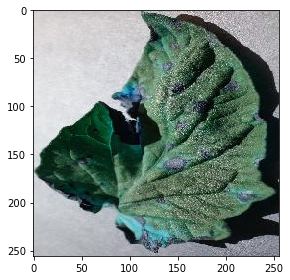

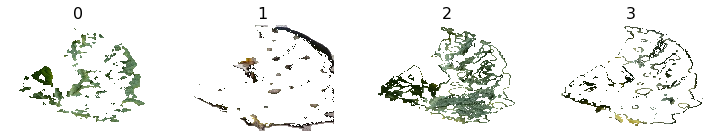

Segmentation Done
Enter Cluster No:3


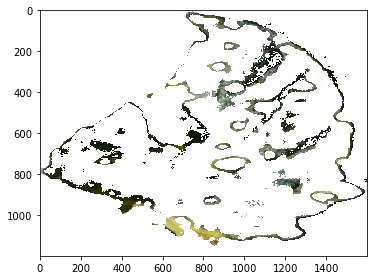

Percent of Infection 16.674420848020038
stage 1


In [ ]:
process("C:/Users/SHUBHAMKUMAR JAIN/Downloads/leaf1.jpg")

Original Image..


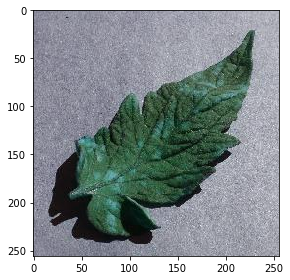

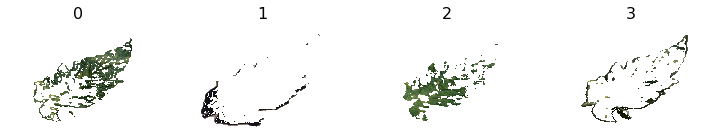

Segmentation Done
Enter Cluster No:1


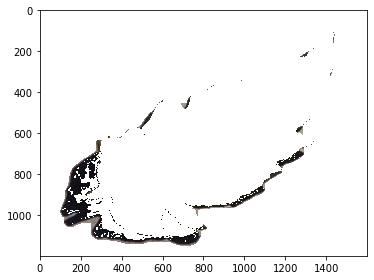

Percent of Infection 11.770545840213082
stage 1


In [ ]:
process("C:/Users/SHUBHAMKUMAR JAIN/Downloads/test.jpg")

Original Image..


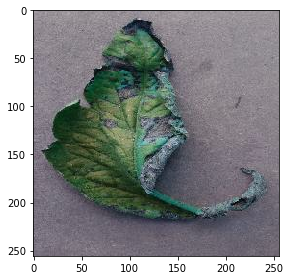

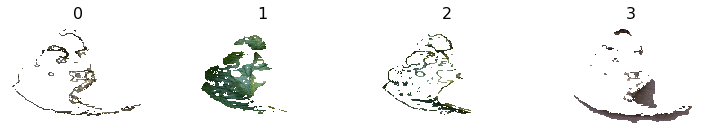

Segmentation Done
Enter Cluster No:0


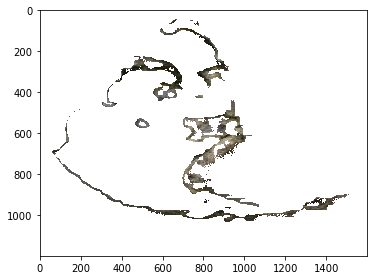

Percent of Infection 15.443319532839688
stage 1


In [ ]:
process("C:/Users/SHUBHAMKUMAR JAIN/Downloads/leaf3.jpg")